## Biweekly Report 5
## Comparitive Analysis of U-Net vs U-Net with Atrous Convolutions and CRF

In this Biweekly Report I wanted to compare traditional U-Net with U-Net with Atrous Convolution and CRF on the Semantic Segmentation task. For this purpose the encoder model I have used is ResNet-34 and the dataset is PASCALVOC 2012 adding another dataset to my knowledge base. Also in the context of this report I wanted to get famaliarized with fastai API, so I have used that for my models. I could have very well written my own code which I did in the past reports but I wanted to explore this API.

In [ ]:
import fastai
from fastai import *
from fastai.vision import *

import pathlib
import os
from PIL import Image
import matplotlib.pyplot as plt

Below I'm trying to mount the drive to my collab to make use of it's GPU, but pushing just the zipped data to the drive took 2 hrs, but collabs GPU compensated for the lost time

In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())
import os
os.chdir("/content/drive/MyDrive")

In [ ]:
import tarfile
fname = "VOCtrainval_11-May-2012.tar"
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()
    

In [ ]:
os.chdir("/content/drive/MyDrive")

In [ ]:
!tar -xvf  'VOCtrainval_11-May-2012.tar' -C 'zipped_VOC/'

VOCdevkit/
VOCdevkit/VOC2012/
VOCdevkit/VOC2012/Annotations/
VOCdevkit/VOC2012/Annotations/2007_000027.xml
VOCdevkit/VOC2012/Annotations/2007_000032.xml
VOCdevkit/VOC2012/Annotations/2007_000033.xml
VOCdevkit/VOC2012/Annotations/2007_000039.xml
VOCdevkit/VOC2012/Annotations/2007_000042.xml
VOCdevkit/VOC2012/Annotations/2007_000061.xml
VOCdevkit/VOC2012/Annotations/2007_000063.xml
VOCdevkit/VOC2012/Annotations/2007_000068.xml
VOCdevkit/VOC2012/Annotations/2007_000121.xml
VOCdevkit/VOC2012/Annotations/2007_000123.xml
VOCdevkit/VOC2012/Annotations/2007_000129.xml
VOCdevkit/VOC2012/Annotations/2007_000170.xml
VOCdevkit/VOC2012/Annotations/2007_000175.xml
VOCdevkit/VOC2012/Annotations/2007_000187.xml
VOCdevkit/VOC2012/Annotations/2007_000241.xml
VOCdevkit/VOC2012/Annotations/2007_000243.xml
VOCdevkit/VOC2012/Annotations/2007_000250.xml
VOCdevkit/VOC2012/Annotations/2007_000256.xml
VOCdevkit/VOC2012/Annotations/2007_000272.xml
VOCdevkit/VOC2012/Annotations/2007_000323.xml
VOCdevkit/VOC2012/A

In [3]:
pascal_voc = pathlib.PosixPath('./VOCdevkit/VOC2012/')
image_ip = pascal_voc/'JPEGImages'
image_lbl = pascal_voc/'SegmentationClass'

In [4]:
codes = np.array(["background","aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair","cow","diningtable","dog","horse","motorbike","person","pottedplant","sheep","sofa","train","tvmonitor"])

In [5]:
files_to_keep = pathlib.PosixPath('./VOCdevkit/VOC2012/ImageSets/Segmentation/')
keep_train_val = files_to_keep/'val.txt'
keep_train_val

PosixPath('VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt')

Below I'm overwriting the Fastai classes to open the Segmentation masks in convert_mode ='P'. A littele bit about the convert_mode 'P':
Normally, images are RGB, which means they have 3 channels, one for red, one for green and one for blue. That normally means that each pixel takes 3 bytes of storage, one for red, one for green and one for blue.

If you have a P mode image, that means it is palettised. That means there is a palette with up to 256 different colours in it, and instead of storing 3 bytes for R, G and B for each pixel, you store 1 byte which is the index into the palette. This confers both advantages and disadvantages. The advantage is that your image requires 1/3 of the space in memory and on disk. The disadvantage is that it can only represent 256 unique colours - so you may get banding or artefacts.

In [6]:
class SegmentationProcessor(PreProcessor):
    "`PreProcessor` that stores the classes for segmentation."
    def __init__(self, ds:ItemList): self.classes = ds.classes
    def process(self, ds:ItemList):  ds.classes,ds.c = self.classes,len(self.classes)

In [7]:
class SegmentationLabelList(ImageList):
    "`ItemList` for segmentation masks."
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)

    def new(self, items, classes=None, **kwargs):
        return self.new(items, ifnone(classes, self.classes), **kwargs)

    def open(self, fn): return open_mask(fn,convert_mode='P')   #HERE
    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): return ImageSegment(t)

In [8]:
class SegmentationItemList(ImageList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = SegmentationLabelList,False

In [9]:
get_y_fn = lambda x: image_lbl/f'{x.stem}.png'  

Preparing the databunch(specific to fastai) for training and evaluating the model

In [10]:

data = (SegmentationItemList.from_folder(image_ip)
        .random_split_by_pct()
        .label_from_func(get_y_fn,classes=codes)
        .transform(get_transforms(),size=224,tfm_y=True)
        .databunch(bs=4))
#          .normalize(imagenet_stats))

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


In [19]:
data.classes

array(['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
       'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype='<U11')

Displaying a few sample images from a batch

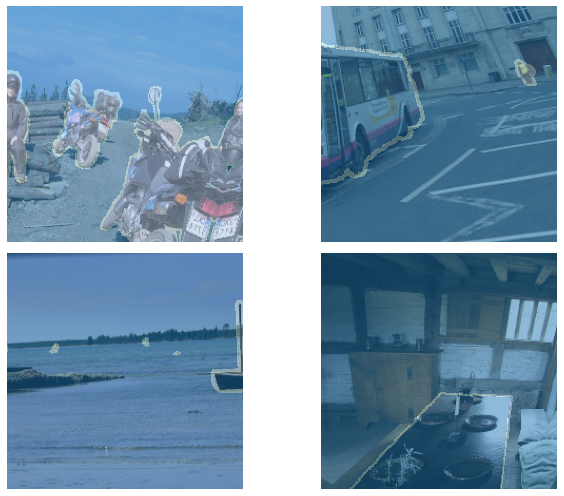

In [20]:
data.show_batch(rows=2,figsize=(10,7))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


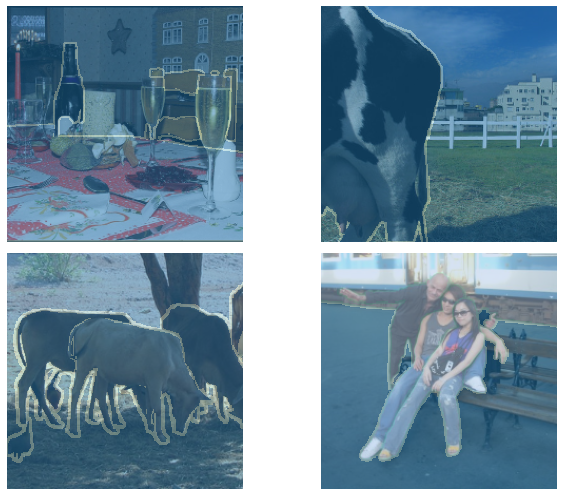

In [21]:
data.show_batch(rows=2,figsize=(10,7),ds_type=DatasetType.Valid)

Created a custom loss function ignoring the index 255 in the target class to ignore the background pixels during the segmentation

In [22]:
def custom_loss(y_hat,y):
    y = y.squeeze(1)
    loss = nn.CrossEntropyLoss(ignore_index=255)
    return loss(y_hat,y)

    
def custom_acc(input,targs):
    targs = targs.squeeze(dim=1)
    input = input.argmax(dim=1)
    
    return (input.flatten()==targs.flatten()).float().mean()

Below I created a U-Net model instance and trying to find the optimum learning rate by recording it in the plot. I particulary found this feature nice in fastai rather than giving a learning rate randomly. Through the plot we can see that the optimum learning rate is 1e-4

In [23]:
learn = unet_learner(data,models.resnet34,metrics=custom_acc,loss_func=custom_loss)

epoch,train_loss,valid_loss,custom_acc,time


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


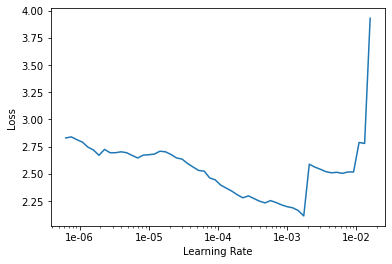

In [24]:
lr_find(learn)
learn.recorder.plot()

Below is the training block, I gave 8 epochs but Collab crashed after 4, so I just continued with that

In [28]:
learn.fit_one_cycle(8,slice(1e-4))

epoch,train_loss,valid_loss,custom_acc,time
0,1.343385,1.246107,0.641039,58:18
1,1.147763,1.074410,0.686459,58:40
2,1.025853,0.874048,0.715636,58:25
3,0.948016,0.798100,0.702334,58:29


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

epoch,train_loss,valid_loss,custom_acc,time
0,1.343385,1.246107,0.641039,58:18
1,1.147763,1.074410,0.686459,58:40
2,1.025853,0.874048,0.715636,58:25
3,0.948016,0.798100,0.702334,58:29


KeyboardInterrupt: ignored

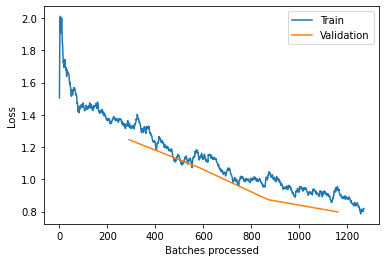

In [29]:
learn.recorder.plot_losses()

In [30]:
img = learn.data.valid_ds[0][0]
learn.predict(img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


(ImageSegment (1, 224, 224), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]), tensor([[[ 3.0978,  3.8164,  4.2145,  ...,  3.8812,  3.0694,  2.6149],
          [ 3.4695,  4.1108,  4.1302,  ...,  4.1979,  3.4671,  2.9952],
          [ 4.3610,  5.5159,  5.0502,  ...,  4.8949,  4.2012,  4.1067],
          ...,
          [ 2.7112,  3.5110,  3.4561,  ...,  6.0795,  5.1759,  4.5738],
          [ 3.0462,  3.1496,  3.4603,  ...,  4.6101,  4.5176,  3.7833],
          [ 2.8217,  3.2750,  3.1485,  ...,  3.9616,  3.6220,  2.9990]],
 
         [[-0.5785, -0.5599, -1.3869,  ..., -1.7669, -1.1446, -1.3573],
          [-0.4730, -0.4340, -1.1527,  ..., -1.6979, -1.0702, -1.3035],
          [-0.5479, -0.3401, -0.4856,  ..., -0.6196, -1.3075, -1.3703],
          ...,
          [-0.7697, -0.3312, -1.0189,  ...,  0.1948, -0.78

So the model definitely performed poorly on the 1st validation image as you can see it didn't identify neither the wine glass nor the bottle which are the ground truths

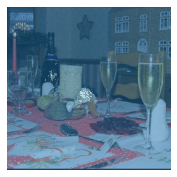

In [31]:
img.show(y=learn.predict(img)[0])

In [32]:
learn.save('stage-1_224',with_opt=False)

On the second validation image it did fairly well, it segmented most part of the cows except their legs, maybe with more epochs this can be achievable

In [33]:
img = learn.data.valid_ds[2][0]

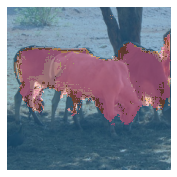

In [34]:
img.show(y=learn.predict(img)[0])

In [39]:
learn.export()

In [41]:
learn.path

PosixPath('VOCdevkit/VOC2012/JPEGImages')

Now below is the prediction on different images which are neither part of train or validation. I loaded the model with empty inference to do the prediction. I also found this feature in fast ai very fascinating coz I did not find this else where. I also got to know the importance of loading the model with empty inference, so that it only has the model parameters and none of the inferences it made/learn during the training


In [45]:
learn.load('stage-1_224',strict=False)

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: SegmentationItemList

y: SegmentationLabelList

Path: VOCdevkit/VOC2012/JPEGImages;

Valid: LabelList (0 items)
x: SegmentationItemList

y: SegmentationLabelList

Path: VOCdevkit/VOC2012/JPEGImages;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [48]:
img = open_image('/content/drive/MyDrive/VOCdevkit/VOC2012/JPEGImages/person_bicycle.jpg')

In [49]:
img.resize(size=224)
img.data.size()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([3, 224, 224])

Below you can see the model segmented the person not so accurately(you can compare with the ground truth) but it completely ignored the cycle. I strongly believe it didnt recognize the cycle because of less epochs

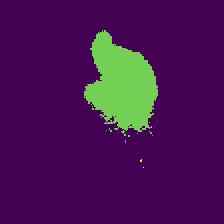

In [50]:
img_pred = learn.predict(img)
img_pred[0]

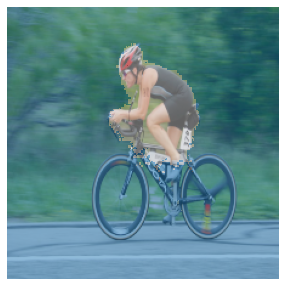

In [51]:
img.show(y=learn.predict(img)[0],figsize=(5,5))

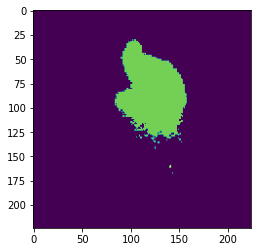

In [52]:
temp = np.array(learn.predict(img)[0].data)
temp = temp.squeeze()
plt.imshow(temp)

Compare the same prediction in the other Notebook where I made the tweaks to U-Net model by adding atrous convolution and CRF. There as well only the person is detected but there is more accuracy there. You can see the map, the above model segmented the person only till 125 mark on y-axis but in the other prediction it went little bit over 125, between 125 and 150. This resonates with the idea of Atrous Convolutions and it's concept of increased Receptive Field.
Therefore I consider this experiment a success as I'm able to achieve practical results with my theoritical knowledge learnt in class